### Import Necessary Module and Set Path 

In [133]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os

In [134]:
import analysis as an

In [135]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./2040_0_015_growth/output.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [136]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

Sink_Source_Inst has no values
Sink_Source_Inst has no values


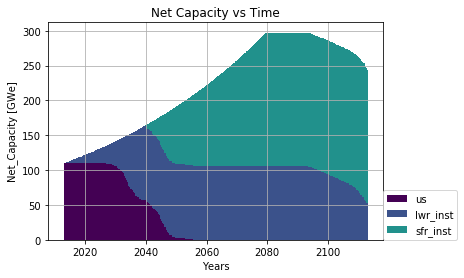

In [137]:
Image('power_plot.png')

In [156]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [157]:
# pu avail timeseries
    
def get_element_inv(cur, z):
    # gets the pu timeseries
    lwr_frac = get_element_content(cur, 'uox_waste', z)
    sfr_frac = get_element_content(cur, 'sfr_used', z)
    legacy_frac = get_element_content(cur, 'pre_2013_unf', z)
    
    storage_id = an.get_agent_ids(cur, 'Storage')
    cool = an.facility_commodity_flux(cur, storage_id,
                                      ['cooled_uox', 'cooled_sfr'],
                                      True, True)
    source_id = an.get_agent_ids(cur, 'Source')
    legacy = an.facility_commodity_flux(cur, source_id, ['pre_2013_unf'], True, True)

    uox_el = np.array(cool['cooled_uox']) * lwr_frac
    sfr_el = np.array(cool['cooled_sfr']) * sfr_frac
    legacy_el = np.array(legacy['pre_2013_unf']) * legacy_frac
    el_dict = {'uox': uox_el, 'sfr': sfr_el, 'legacy': legacy_el}
    return el_dict




In [160]:
# pu usage
def get_element_usage(cur, z):
    sfr_in_el_frac = get_element_content(cur, 'sfr_fuel_legacy', z)

    # fuel input
    mixer =an.get_agent_ids(cur, 'mixer')
    fuel_usage = an.facility_commodity_flux(cur, mixer,
                                        ['sfr_fuel_legacy', 'sfr_fuel_new'],
                                        True, True)
    el_use_dict = {'from_uox': np.array(fuel_usage['sfr_fuel_legacy']) * sfr_in_el_frac,
                   'from_sfr': np.array(fuel_usage['sfr_fuel_new']) * sfr_in_el_frac}
    return el_use_dict


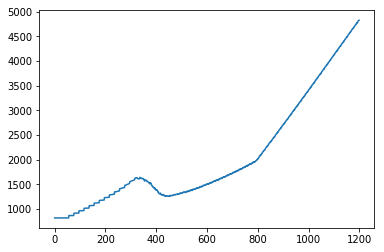

In [161]:
plt.close()

# pu accumulation and usage timeseries
pu_dict = get_element_inv(cur, 94)
pu_usage = get_element_usage(cur, 94)

net = sum(pu_dict.values()) -sum(pu_usage.values())
plt.plot(net)
plt.show()
plt.close()


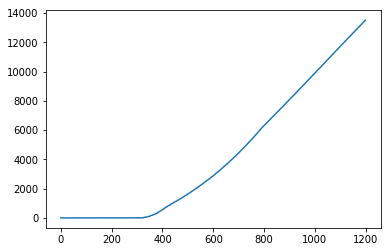

In [146]:
plt.plot(sum(pu_usage.values()))

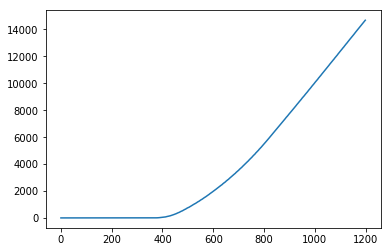

In [142]:
plt.plot(pu_dict['sfr'])

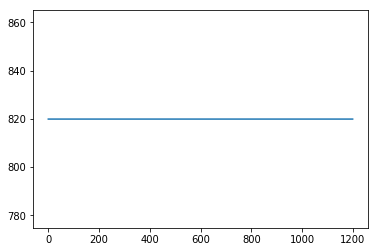

In [143]:
plt.plot(pu_dict['legacy'])

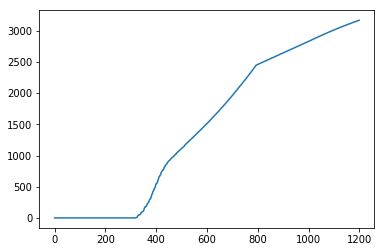

In [144]:
plt.plot(pu_usage['from_uox'])

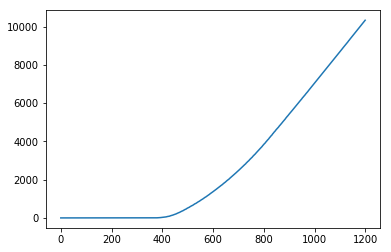

In [145]:
plt.plot(pu_usage['from_sfr'])

In [ ]:
uox = an.get_agent_ids(cur, 'reactor')
influx = an.facility_commodity_flux(cur, uox,
                                         ['uox_waste'],
                                         True, False)
plt.plot(influx['uox_waste'])


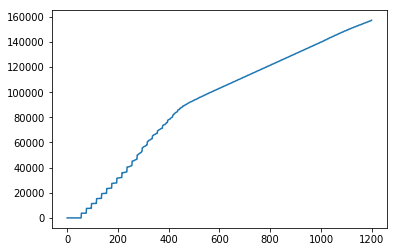

In [65]:

uox_rep = an.get_prototype_id(cur, 'reprocessing')
influx = an.facility_commodity_flux(cur, uox_rep,
                                         ['cooled_uox', 'pre_2013_unf'],
                                         False, True)
total = [x+y for x,y in zip(influx['cooled_uox'], influx['pre_2013_unf'])]
total = influx['cooled_uox']
plt.plot(total)

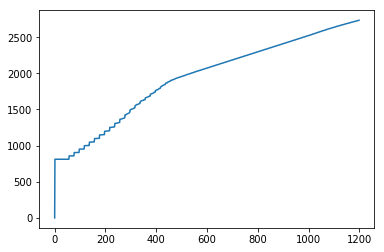

In [66]:
uox_rep = an.get_prototype_id(cur, 'reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['lwr_pu'],
                                         True, True)
plt.plot(outflux['lwr_pu'])


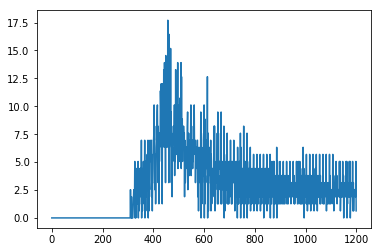

In [29]:
uox_rep = an.get_prototype_id(cur, 'sfr_reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['sfr_pu'],
                                         True, False)
plt.plot(outflux['sfr_pu'])


157199.437


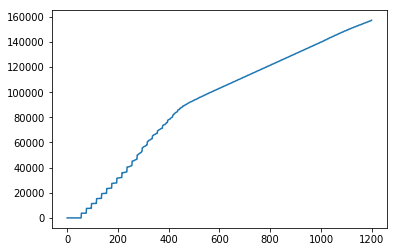

In [76]:
uox_unf = an.get_agent_ids(cur, 'storage')
uox = an.facility_commodity_flux(cur, uox_unf, ['cooled_uox'], True, True)
plt.plot(uox['cooled_uox'])
print(uox['cooled_uox'][-1])

[     0.        0.        0.   ... 405799.68 405936.96 406211.52]


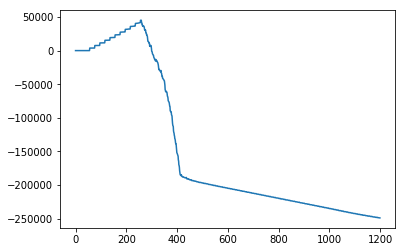

In [77]:
lwr_mixer = an.get_prototype_id(cur, 'sfr_mixer_lwr')
outflux = an.facility_commodity_flux(cur, lwr_mixer,
                                     ['sfr_fuel_legacy'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_legacy'])
unf_for_sfr_fuel = 1 * 0.0869 / (0.01)
influx = an.facility_commodity_flux(cur, lwr_mixer, ['lwr_pu'], False, True)
unf_needed = outflux * unf_for_sfr_fuel
print(unf_needed)
plt.plot(np.array(uox['cooled_uox']) - unf_needed)

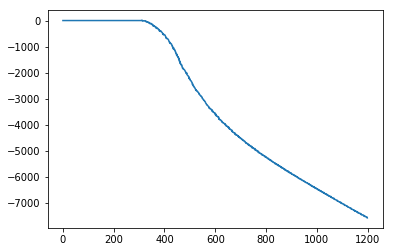

In [30]:
sfr_mixer = an.get_prototype_id(cur, 'sfr_mixer_sfr')
outflux = an.facility_commodity_flux(cur, sfr_mixer,
                                     ['sfr_fuel_new'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_new'])
influx = an.facility_commodity_flux(cur, sfr_mixer, ['sfr_pu'], False, True)
influx = np.array(influx['sfr_pu']) / 0.22
plt.plot(influx - outflux)